<a href="https://colab.research.google.com/github/LordFlumpleNerf/BadAssStockPickerAI/blob/main/StockPickerAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### THIS BLOCK IS A CATCH-ALL FOR SHIT TO IMPORT AND SETUP

import matplotlib.pyplot as plt
import yfinance as yf
import alpha_vantage
import requests
import json
#import nasdaq_data_link

import tensorflow as tf
from tensorflow import keras
from keras import models, layers, callbacks
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import train_test_split
from datetime import datetime, date, timedelta
import random
import time

import numpy as np
import pandas as pd
import openpyxl
import pytz

%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', 300000)
pd.set_option('display.colheader_justify', 'center')
pd.options.mode.chained_assignment = None

In [ ]:
av_api_key = "API_KEY_from_Alpha_Vantage"
alpha_vantage_url = 'https://www.alphavantage.co/query'

sample_size = 320

In [ ]:
#drawing our tickers from iShares ICLN fund or iShares Core Small Cap ETF
### ADDED COLUMN IN EACH UNDER 'usecols' FOR SECTOR

#stocklist = pd.read_excel('drive/My Drive/iShares-Global-Clean-Energy-ETF_fund.xlsx', sheet_name='Holdings', usecols='A,D,E,L', skiprows=7)
#stocklist = pd.read_excel('drive/My Drive/iShares-Core-SP-Small-Cap-ETF_fund.xlsx', sheet_name='Holdings', usecols='A,D,E,L', skiprows=7)
#stocklist = pd.read_excel('drive/My Drive/iShares-Core-SP-Total-US-Stock-Market-ETF_fund.xlsx', sheet_name='Holdings', usecols='A,C,D,K', skiprows=7)

mid_caps = pd.read_excel('drive/My Drive/iShares-Core-SP-Mid-Cap-ETF_fund.xlsx', sheet_name='Holdings', usecols='A,D,E,L', skiprows=7)
large_caps = pd.read_excel('drive/My Drive/iShares-Core-SP-500-ETF_fund.xlsx', sheet_name='Holdings', usecols='A,C,D,K', skiprows=7)

stocklist = pd.concat([large_caps, mid_caps])
stocklist.reset_index(drop=True)

del mid_caps
del large_caps

In [ ]:
#Creating initial ticker list from ICLN or Small-Cap tickers
### CHANGING TO A DATAFRAME TO ADD SECTOR
stocklist = stocklist[(stocklist['Asset Class'] == 'Equity')]
stocklist = stocklist[(stocklist['Exchange'] == 'NASDAQ') | (stocklist['Exchange'] == 'New York Stock Exchange Inc.')]
print(stocklist.head())
print(stocklist.tail())
stocklist = stocklist[['Ticker', 'Sector']].sample(sample_size)

  Ticker          Sector         Asset Class Exchange
0   AAPL  Information Technology    Equity    NASDAQ 
1   MSFT  Information Technology    Equity    NASDAQ 
2   AMZN  Consumer Discretionary    Equity    NASDAQ 
3   NVDA  Information Technology    Equity    NASDAQ 
4  GOOGL           Communication    Equity    NASDAQ 
    Ticker          Sector         Asset Class            Exchange          
404   ENV   Information Technology    Equity    New York Stock Exchange Inc.
405  STWD               Financials    Equity    New York Stock Exchange Inc.
408   CUZ              Real Estate    Equity    New York Stock Exchange Inc.
410   AFG               Financials    Equity    New York Stock Exchange Inc.
411  UBSI               Financials    Equity                          NASDAQ


In [ ]:
### one-hot encoding for 'sector'
ticker = stocklist['Ticker']
sector = pd.get_dummies(stocklist['Sector'])
stocklist = pd.concat([ticker, sector], axis=1)
stocklist[sector.columns] = stocklist[sector.columns].astype(float)
stocklist.reset_index(drop=True, inplace=True)

#print(stocklist.head())
del sector


In [ ]:
def get_indices(index_ticker, period):
    # for getting index dataframes for each important index
    ticker = yf.Ticker(index_ticker)

    #initializing the frame
    df = pd.DataFrame(ticker.history(period=period))
    #df.reset_index(drop=True, inplace=True)
    df.drop(columns=['Dividends', 'Stock Splits'], axis=1, inplace=True)
    if index_ticker == '^VIX':
        df.drop(['Volume'], axis=1, inplace=True)

    return df

In [ ]:
def get_cpi(start_date):
    # alpha_vantage getting cpi data
    params = {
        'function': 'CPI',
        'interval': 'monthly',
        'apikey': av_api_key
        }

    response = requests.get(alpha_vantage_url, params)
    data = response.json()
    cpi = pd.DataFrame(data['data'])
    cpi = cpi.iloc[::-1]
    cpi.set_index('date', inplace=True)
    cpi = cpi[start_date:]
    cpi.reset_index(inplace=True)
    starting_cpi = cpi['value'].loc[0]

    return cpi, starting_cpi


In [ ]:
def get_ffr(start_date):
    # alpha_vantage getting federal funds rate
    params = {
        'function': 'FEDERAL_FUNDS_RATE',
        'interval': 'daily',
        'apikey': av_api_key
        }

    response = requests.get(alpha_vantage_url, params)
    data = response.json()
    ffr = pd.DataFrame(data['data'])
    ffr = ffr.iloc[::-1]
    ffr.set_index('date', inplace=True)
    ffr = ffr[start_date:]
    ffr.reset_index(inplace=True)

    return ffr

In [ ]:
def get_earnings(ticker):
    # We are going to alpha_vantage for this
    params = {
        'function': 'EARNINGS',
        'symbol': ticker,
        'outputsize': 'full',
        'datatype': 'json',
        'apikey': av_api_key
        }

    try:
        response = requests.get(alpha_vantage_url, params)
        data = response.json()
        quarterly_earnings = pd.DataFrame(data['quarterlyEarnings'])
        quarterly_earnings['fiscalDateEnding'] = pd.to_datetime(quarterly_earnings['fiscalDateEnding'])

        return quarterly_earnings

    except Exception as e:
        print("An exception occurred: ", e)

        return e

In [ ]:
def create_frame(stock_ticker, timeframe, future_offset, index_length, merged_economic_data, period='max'):
    #creating and forming the master frame, converting data to float (except for ticker which will be done later)
    #data taken from yahoo finance
    ### TAKING OUT DATE COLUMNS AS THEY COULD CORRUPT RESULTS SINCE DATE FOR PREDICTION DATA WILL ALWAYS BE CURRENT

    # Create the initial dataframe
    try:
        ticker = yf.Ticker(stock_ticker)

        #initializing the frame
        df = pd.DataFrame(ticker.history(period=period))
    except ValueError as e:
        if str(e) == f"{stock_ticker}: No data found, symbol may be delisted":
            print(f"Symbol {symbol} is not available.")
        else:
          raise e

    if df.empty:
        raise DataError(f"No data available for {ticker}.")
    elif len(df) < index_length:
        raise DataError(f"Insufficient data available for {ticker}.")
    elif df.isna().values.any():
        raise DataError(f"Null values found for {ticker}.")

    # Now create the earnings dataframe and prepare it
    try:
        df_earnings = get_earnings(stock_ticker)
        df_earnings = df_earnings.iloc[::-1]
        df_earnings.reset_index(drop=True, inplace=True)
    except Exception:
        pass

    df_earnings['reportedEPS'] = df_earnings['reportedEPS'].replace('None', 0.0)
    df_earnings['estimatedEPS'] = df_earnings['estimatedEPS'].replace('None', 0.0)
    df_earnings['surprise'] = df_earnings['surprise'].replace('None', 0.0)
    df_earnings['surprisePercentage'] = df_earnings['surprisePercentage'].replace('None', 0.0)

    # Now combine earnings and also cpi and federal funds rate data

    #initialize earnings to 0.0
    df['reportedEPS'] = 0.0
    df['estimatedEPS'] = 0.0
    df['surprise'] = 0.0
    df['surprisePercentage'] = 0.0

    #set up a date column for our loops
    df['date'] = pd.to_datetime(df.index.date)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')

    df.reset_index(drop=True, inplace=True)

    #earnings loop
    for i in range(len(df)):
        target_date = df.loc[i, 'date']

        #add in earnings
        for j in range(len(df_earnings)):
            reported_date = df_earnings.loc[j, 'reportedDate']
            if reported_date == target_date:
                df.loc[i, 'reportedEPS'] = df_earnings.loc[j, 'reportedEPS']
                df.loc[i, 'estimatedEPS'] = df_earnings.loc[j, 'estimatedEPS']
                df.loc[i, 'surprise'] = df_earnings.loc[j, 'surprise']
                df.loc[i, 'surprisePercentage'] = df_earnings.loc[j, 'surprisePercentage']
            else:
                continue

    #merge in economics
    df = pd.merge(df, merged_economic_data, on='date', how='left')
    df.fillna(method='ffill', inplace=True)

    df = df.drop('date', axis=1)
    df.reset_index(drop=True, inplace=True)

    #converting some things to type float and calculating "future close" which is a column for price "future_offset" days in the future
    df['Dividends'] = df['Dividends'].astype('float')
    df['Stock Splits'] = df['Stock Splits'].astype('float')
    df['Volume'] = df['Volume'].astype('float')
    df['Future Close'] = df['Close'].shift(-(future_offset))

    #getting most recent close
    most_recent_close = df['Close'].iloc[-1]

    del df_earnings

    return df, most_recent_close

In [ ]:
def create_sets(frame, timeframe, future_offset, input_scaler, number_of_selections=20):
    #Creating the X and ys for each individual stock
    # THIS FUNCTION RETURNS A LIST CONTAINING FRAMES FOR ONE STOCK

    #initializing train, test, and validation
    train_X = []
    train_y = []
    validation_X = []
    validation_y = []
    prediction_set = []

    #creating the prediction set and adding one_hot
    predict_set = frame.iloc[-timeframe:].drop(['Future Close'], axis=1)
    predict_set.reset_index(drop=True, inplace=True)
    predict_set = input_scaler.transform(predict_set)
    prediction_set.append(predict_set)

    #dropping future_offset as it contains unpredictable values for future_close and move_level
    frame = frame.iloc[:-future_offset]

    #creating a sample size to be divided among sets
    #number_of_selections = int((len(frame)) / ((timeframe) / 3))

    training_size = int(number_of_selections * .8)
    training_selections = random.sample(range(len(frame)-timeframe), training_size)
    for i in training_selections:
        X_frame = frame.iloc[i:i+timeframe].drop(['Future Close'], axis=1)
        X_frame.reset_index(drop=True, inplace=True)
        X_frame = input_scaler.transform(X_frame)
        y = frame.iloc[i+timeframe]['Future Close']
        train_X.append(X_frame)
        train_y.append(y.item())

    validation_size = int(number_of_selections * .2)
    validation_selections = random.sample(range(len(frame)-timeframe), validation_size)
    for i in validation_selections:
        X_frame = frame.iloc[i:i+timeframe].drop(['Future Close'], axis=1)
        X_frame.reset_index(drop=True, inplace=True)
        X_frame = input_scaler.transform(X_frame)
        y = frame.iloc[i+timeframe]['Future Close']
        validation_X.append(X_frame)
        validation_y.append(y.item())

    return train_X, train_y, validation_X, validation_y, prediction_set

In [ ]:
def prepare_data(combined_frames, timeframe, future_offset, input_scaler, number_of_selections=20): #removed scaler
    # The catch all function to run the functions that organize the data
    # will return list of dataframes that are scaled
    train_data = []
    train_labels = []
    validation_data = []
    validation_labels = []
    predict_data = []
    for each in combined_frames:
        #scaled_frame = scale_data(combined_frames[each])#, scaler)
        t_X, t_y, v_X, v_y, p_s = create_sets(combined_frames[each], timeframe, future_offset, input_scaler, number_of_selections)
        train_data.extend(t_X)
        train_labels.extend(t_y)
        validation_data.extend(v_X)
        validation_labels.extend(v_y)
        predict_data.extend(p_s)

    return train_data, train_labels, validation_data, validation_labels, predict_data

In [ ]:
def combine_with_indexes(index_dict, frame_dict):
        #redoing the dictionary of frames to add stock indexes for the same date ranges
    new_frame_dict = {
        ticker: pd.concat([frame, pd.concat(index_dict.values(), axis=1)], axis=1)
        for ticker, frame in frame_dict.items()
    }

    return new_frame_dict

In [ ]:
class DataError(Exception):
    #creating an exception class to ensure adequate data per stock in list
    pass

In [ ]:
def array_stacker(dataframe_list):
    #converting input dataframes into appropriate tensor form
    return tf.stack([dataframe_list])

def label_stacker(label_list):
    #converting labels into appropriate tensor form
    return tf.stack([label_list[each] for each in range(len(label_list))])

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [ ]:
indices = {
    'SPX':'^GSPC',
    'Dow':'^DJI',
    'Nasdaq':'^IXIC',
    'Russell':'^RUT',
    'NYSE':'^NYA',
    'AMEX':'^XAX',
    'XLF':'XLF',
    'XLE':'XLE',
    'XLU':'XLU',
    'XLB':'XLB',
    'XLI':'XLI',
    'XLY':'XLY',
    'XLV':'XLV',
    'SMH':'SMH',
    'XLP':'XLP',
    'XTL':'XTL',
    'IYR':'IYR',
    'VIX':'^VIX'
    }

In [ ]:
timeframe = 20
period = '5y'
future_offset = 1
number_of_selections = 100

# Create dictionary of dataframes for indices
index_dict = {}
start_date = str(0)
for key, value in indices.items():
    df = get_indices(value, period)
    if key == 'SPX':
        start_date = df.index[0].strftime('%Y-%m-%d')
    df.reset_index(drop=True, inplace=True)
    index_dict[key] = df

index_length = len(index_dict['SPX'])-1

In [ ]:
# let's define a few global variable dataframes to reuse
ffr = get_ffr(start_date)
cpi, starting_cpi = get_cpi(start_date)
cpi.loc[cpi['value'].isna(), 'value'] = starting_cpi

merged_economic_data = pd.merge(ffr, cpi, on='date', how='left')
merged_economic_data['value_y'].fillna(method='ffill', inplace=True)
merged_economic_data.loc[merged_economic_data['value_y'].isna(), 'value_y'] = starting_cpi
merged_economic_data.rename(columns={'value_x': 'ffr', 'value_y': 'cpi'}, inplace=True)

x = 0
frame_dict = {}
close_dict = {}

sector_columns = [stocklist.columns[1:].tolist()]

for idx, row in stocklist.iterrows():
    time.sleep(15)
    ticker = row['Ticker']
    if x < 100:
        print(ticker, end=", ")
        x += 1
    else:
        print(ticker)
        print()
        x = 0
        time.sleep(600)

    try:
        frame, most_recent_close = create_frame(ticker, timeframe, future_offset, index_length, merged_economic_data, period)
        for each in sector_columns:
            frame[each] = row[each]
        frame_dict[ticker] = frame
        close_dict[ticker] = most_recent_close

    except Exception as e:
        print(f"Error for {ticker}: {e}")
        pass

del stocklist

DXCM, EMN, SWKS, TMHC, VZ, AAPL, PNFP, CNC, HAL, IBOC, ARWR, NOC, BIIB, KEYS, PEAK, LW, FOXF, ARE, DAR, MS, MP, Error for MP: Insufficient data available for yfinance.Ticker object <MP>.
PVH, KBH, WMS, CMG, PARA, DVN, VNT, Error for VNT: Insufficient data available for yfinance.Ticker object <VNT>.
GEN, INCY, BSX, BJ, Error for BJ: Insufficient data available for yfinance.Ticker object <BJ>.
KSS, RGEN, LNW, RGA, EMR, YETI, Error for YETI: Insufficient data available for yfinance.Ticker object <YETI>.


ERROR BFB: No data found, symbol may be delisted
ERROR:yfinance:BFB: No data found, symbol may be delisted


BFB, Error for BFB: No data available for yfinance.Ticker object <BFB>.
PGR, BKR, AMG, SLAB, COTY, UNM, CHDN, PCG, WRK, FISV, Error for FISV: Insufficient data available for yfinance.Ticker object <FISV>.
HWC, MMM, IQV, ACM, ORA, ES, VAC, STAA, CDNS, NFG, MTD, PBF, CASY, TSLA, IRT, MSFT, OLED, OGN, Error for OGN: Insufficient data available for yfinance.Ticker object <OGN>.
HON, SYF, AMGN, QRVO, ARMK, TRMB, GOOGL, CFG, MDU, CAT, NVR, NSA, HBAN, MCHP, ISRG, LMT, DD, WELL, WOR, WEN, STT, SNV, HPQ, LVS, AIZ, EEFT, FAST, PSA, PGNY, Error for PGNY: Insufficient data available for yfinance.Ticker object <PGNY>.
EQR, ESS, KMI, WTFC, ALE

CXT, CB, SYY, FCFS, PZZA, AAL, EFX, KMX, TNL, BKNG, DAN, BC, ACGL, CTLT, BBWI, TCBI, UDR, CBSH, MAC, ROL, PH, SPG, NEOG, KRG, SIGI, HXL, FLO, HGV, CZR, SNX, CDAY, TEX, DRI, CMS, ALGN, ICE, TJX, UMBF, SAM, SRCL, MPC, HIG, PK, GL, COHR, AMD, META, LOW, KBR, AMED, THG, PRI, APD, TPX, KMPR, NWSA, EPAM, FTV, KHC, ZBH, PG, K, VRTX, CL, FDX, AMKR, OLLI, CAG, CLH, BL

In [ ]:
combined_frames = combine_with_indexes(index_dict, frame_dict)

del index_dict

scaler = MinMaxScaler()
scale_input_frame = pd.concat(combined_frames)
scale_input_frame = scale_input_frame.drop(columns=['Future Close'])
input_scaler = scaler.fit(scale_input_frame)

train_data, train_labels, validation_data, validation_labels, predict_data = prepare_data(combined_frames, timeframe, future_offset, input_scaler, number_of_selections)
del combined_frames

In [ ]:
scale_labels = train_labels + validation_labels
output_scaler = scaler.fit(np.array(scale_labels).reshape(len(scale_labels), 1))

In [ ]:
input_X = array_stacker(train_data)
input_y = output_scaler.transform(np.array(train_labels).reshape(-1, 1))

validation_X = array_stacker(validation_data)
validation_y = output_scaler.transform(np.array(validation_labels).reshape(-1, 1))

predict_X = array_stacker(predict_data)

In [ ]:
input_X = tf.reshape(input_X, (input_X.shape[1], input_X.shape[2], input_X.shape[3]))
input_y = tf.reshape(input_y, (input_y.shape[0], 1))
validation_X = tf.reshape(validation_X, (validation_X.shape[1], validation_X.shape[2], validation_X.shape[3]))
validation_y = tf.reshape(validation_y, (validation_y.shape[0], 1))
predict_X = tf.reshape(predict_X, (predict_X.shape[1], predict_X.shape[2], predict_X.shape[3]))

In [ ]:
model_3 = Sequential([
        tf.keras.layers.LSTM(32, dropout=.25, activation='tanh', return_sequences=True),# return_sequences=True)),
        tf.keras.layers.LSTM(16, dropout=.25, activation='tanh', return_sequences=True),
        tf.keras.layers.LSTM(8),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
])

model_3.compile(optimizer='Adam', loss='mse', metrics=[rmse])

In [ ]:
batch_size = 32
epochs = 10000

history_3 = model_3.fit(x=input_X,
              y=input_y,
              batch_size=batch_size,
              epochs=epochs,
              verbose=2,
              validation_data=(validation_X, validation_y),
              callbacks=EarlyStopping(monitor='val_rmse', restore_best_weights=True, patience=150)
            )

Epoch 1/10000
758/758 - 22s - loss: 0.0012 - rmse: 0.0258 - val_loss: 5.4990e-04 - val_rmse: 0.0138 - 22s/epoch - 29ms/step
Epoch 2/10000
758/758 - 7s - loss: 2.8248e-04 - rmse: 0.0153 - val_loss: 3.8045e-04 - val_rmse: 0.0133 - 7s/epoch - 10ms/step
Epoch 3/10000
758/758 - 7s - loss: 2.0585e-04 - rmse: 0.0132 - val_loss: 2.8921e-04 - val_rmse: 0.0121 - 7s/epoch - 9ms/step
Epoch 4/10000
758/758 - 7s - loss: 1.8144e-04 - rmse: 0.0120 - val_loss: 2.2906e-04 - val_rmse: 0.0108 - 7s/epoch - 10ms/step
Epoch 5/10000
758/758 - 7s - loss: 1.8734e-04 - rmse: 0.0111 - val_loss: 1.1277e-04 - val_rmse: 0.0088 - 7s/epoch - 10ms/step
Epoch 6/10000
758/758 - 7s - loss: 1.0080e-04 - rmse: 0.0086 - val_loss: 9.3235e-05 - val_rmse: 0.0080 - 7s/epoch - 9ms/step
Epoch 7/10000
758/758 - 7s - loss: 9.9523e-05 - rmse: 0.0084 - val_loss: 1.0258e-04 - val_rmse: 0.0089 - 7s/epoch - 10ms/step
Epoch 8/10000
758/758 - 7s - loss: 1.5966e-04 - rmse: 0.0102 - val_loss: 8.1674e-05 - val_rmse: 0.0080 - 7s/epoch - 9ms/st

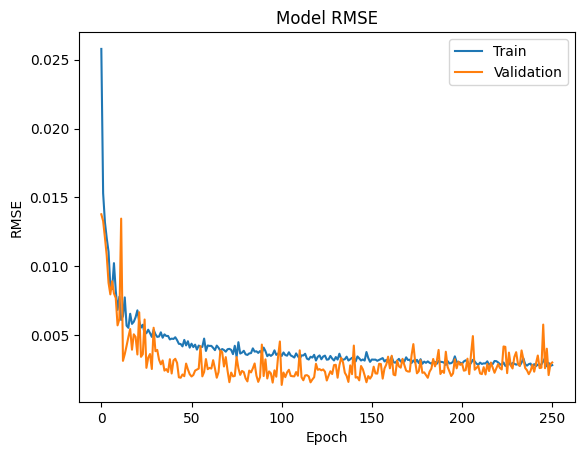

Last:  0.003025512211024761 Best:  0.0013965214602649212


In [ ]:
plt.plot(history_3.history['rmse'])
plt.plot(history_3.history['val_rmse'])
plt.title('Model RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Extract the RMSE values from the history
rmse_values3 = history_3.history['val_rmse']

# Extract the final and lowest RMSE values
print("Last: ", rmse_values3[-1], "Best: ", min(rmse_values3))

In [ ]:
predictions = output_scaler.inverse_transform(model_3.predict(predict_X))

10/10 [==============================] - 1s 4ms/step


In [ ]:
results = pd.DataFrame()
results['Ticker'] = frame_dict.keys()
results['Most Recent Close'] = [close_dict[each] for each in results['Ticker']]
results['Predicted Price'] = predictions
results['Percent Change'] = ((results['Predicted Price'] - results['Most Recent Close']) / results['Most Recent Close']) * 100

In [ ]:
print(results.sort_values(by='Percent Change', ascending=False))

    Ticker  Most Recent Close  Predicted Price  Percent Change
279     UA        6.560000         18.493687      181.915958  
276    UAA        7.140000         18.728367      162.302062  
243    GPS        8.690000         19.329197      122.430355  
207   VTRS        9.760000         19.958561      104.493447  
72    HBAN       10.210000         18.249979       78.746121  
111    MAC       10.430000         16.994772       62.941241  
38    COTY       12.220000         19.467171       59.305813  
253      M       15.000000         22.434029       49.560191  
135     PK       12.310000         18.200676       47.852765  
103    DAN       15.760000         22.180748       40.740785  
24    PARA       15.360000         21.336479       38.909373  
215    DOC       13.480000         18.547775       37.594777  
234    RCM       17.530001         23.809240       35.819962  
208    JWN       18.170000         24.321310       33.854210  
98     AAL       16.260000         21.747328       33.7

In [ ]:
shortened_results = results.drop(results[results['Most Recent Close'] < 1.00].index)
print(shortened_results.sort_values(by='Percent Change', ascending=False))

    Ticker  Most Recent Close  Predicted Price  Percent Change
279     UA        6.560000         18.493687      181.915958  
276    UAA        7.140000         18.728367      162.302062  
243    GPS        8.690000         19.329197      122.430355  
207   VTRS        9.760000         19.958561      104.493447  
72    HBAN       10.210000         18.249979       78.746121  
111    MAC       10.430000         16.994772       62.941241  
38    COTY       12.220000         19.467171       59.305813  
253      M       15.000000         22.434029       49.560191  
135     PK       12.310000         18.200676       47.852765  
103    DAN       15.760000         22.180748       40.740785  
24    PARA       15.360000         21.336479       38.909373  
215    DOC       13.480000         18.547775       37.594777  
234    RCM       17.530001         23.809240       35.819962  
208    JWN       18.170000         24.321310       33.854210  
98     AAL       16.260000         21.747328       33.7

In [ ]:
# Code for saving shortened_results into Excel
writer = pd.ExcelWriter('drive/My Drive/AI Predictions.xlsx', engine='openpyxl')
tz = pytz.timezone('US/Eastern')
today = datetime.now(tz).strftime('%Y-%m-%d')
shortened_results.to_excel(writer, sheet_name=today, index=False)

# Accessing the workbook and active sheet
workbook  = writer.book
worksheet = writer.sheets[today]

# Setting column width based on the maximum length of each column header
for i, column in enumerate(shortened_results.columns):
    column_length = max(shortened_results[column].astype(str).map(len).max(), len(column))
    worksheet.column_dimensions[openpyxl.utils.get_column_letter(i+1)].width = column_length + 2

writer.close()